In [1]:
from pyvis.network import Network
import pandas as pd
# import dynetx as dn
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pathpy as pp
import json
import numpy as np
from matplotlib.widgets import Slider
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import tkinter as tk
%matplotlib notebook

In [2]:
network = {}

In [19]:
with open("../datasets/Railway.csv") as f:
    k= 0

    prev_train = None
    prev_station = None

    for line in f:
        train, st_no, st_id, date, arr_time, dep_time, stay_time, mileage, lat, lon = line.split(",")
        lat = float(lat)
        lon = float(lon)

        #convert h;m to minutes

        try:
            dep_time = int(dep_time.split(":")[0]) * 60 + int(dep_time.split(":")[1])
            arr_time = int(arr_time.split(":")[0]) * 60 + int(arr_time.split(":")[1])
            if date == "Day 2":
                arr_time+= 24*60
                dep_time+= 24*60

            elif date == "Day 3":
                arr_time+= 48*60
                dep_time+= 48*60
        except:
            k+=1
            dep_time = None
            arr_time = None

        if train != prev_train:
            prev_station = None
            network[train] = []

        station = {
            "id": int(st_id),
            "name": f"Station {st_id}",
            "lat": lat,
            "lon": lon,
            "start": dep_time,
            "end": None,
            "from": prev_station["lat"] if prev_station else None,
            "to": None,
        }

        network[train].append(station)

        if prev_station:
            prev_station["to"] = (lat, lon)
            prev_station["end"] = arr_time

        prev_train = train
        prev_station = station
    print(k)

6022


In [13]:
#create hashtable of station id and (lat,long) as key
station_id = {}
for train in network:
    for station in network[train]:

        station_id[(station['lat'], station['lon'])] = station['id']

In [14]:
# create an empty graph
G = nx.MultiDiGraph()

# add nodes to the graph
for stations in network:
    for station in network[stations]:
        # print(station)
        #add note with the localisation for visualization
        G.add_node(station['id'], pos=(station['lon'], station['lat']))


# add edges to the graph
for stations in network:
    for station in network[stations]:
        from_node = station['id']
        to_node = None

        if type(station['to']) is tuple:
            # if the 'to' value is a tuple, create a new node
            to_node = station_id[station['to']]
            G.add_edge(from_node, to_node)
        else:
            continue


print("Multi Directed Graph:")
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())
print("\nDirected Graph:")

#convert to directed graph
G_directed = nx.DiGraph()
for u,v in G.nodes(data=True):
    G_directed.add_node(u, pos=v['pos'])
for u,v in G.edges():
    if G_directed.has_edge(u,v):
        continue
    else:
        G_directed.add_edge(u, v)

print("Number of nodes: ", G_directed.number_of_nodes())
print("Number of edges: ", G_directed.number_of_edges())
print("\nUndirected Graph:")

G_undirected = G_directed.to_undirected()
print("Number of nodes: ", G_undirected.number_of_nodes())
print("Number of edges: ", G_undirected.number_of_edges())

Multi Directed Graph:
Number of nodes:  2719
Number of edges:  64155

Directed Graph:
Number of nodes:  2719
Number of edges:  10778

Undirected Graph:
Number of nodes:  2719
Number of edges:  6175


# Graph Statistics

In [14]:
print("Graph Statistics:")
print("Clustering Coefficient: \t", nx.average_clustering(G_directed))
# print("Average Shortest Path Length: \t", nx.average_shortest_path_length(G_directed))
# print("Diameter: \t", nx.diameter(G_directed))
# print("Radius: \t", nx.radius(G_directed))
print("Number of Nodes: \t", G_directed.number_of_nodes())
print("Number of Edges: \t", G_directed.number_of_edges())
print("Density: \t", nx.density(G_directed))
print("Transitivity: \t", nx.transitivity(G_directed))
print("Average Degree: \t", np.mean(list(dict(G_directed.degree()).values())))
print("Average Clustering: \t", np.mean(list(nx.clustering(G_directed).values())))
print("Average Eigenvector Centrality: \t", np.mean(list(nx.eigenvector_centrality(G_directed).values())))
print("Average Betweenness Centrality: \t", np.mean(list(nx.betweenness_centrality(G_directed).values())))
print("Average Closeness Centrality: \t", np.mean(list(nx.closeness_centrality(G_directed).values())))
print("Average Degree Centrality: \t", np.mean(list(nx.degree_centrality(G_directed).values())))
print("Average Page Rank: \t", np.mean(list(nx.pagerank(G_directed).values())))
print("Average Harmonic Centrality: \t", np.mean(list(nx.harmonic_centrality(G_directed).values())))
print("Average Load Centrality: \t", np.mean(list(nx.load_centrality(G_directed).values())))

Graph Statistics:
Clustering Coefficient: 	 0.36475104965625976
Number of Nodes: 	 2546
Number of Edges: 	 9948
Density: 	 0.0015352870638020732
Transitivity: 	 0.291138628228693
Average Degree: 	 7.814611154752553
Average Clustering: 	 0.36475104965625943
Average Eigenvector Centrality: 	 0.006363961435859404
Average Betweenness Centrality: 	 0.003361747107840058
Average Closeness Centrality: 	 0.10919472166281022
Average Degree Centrality: 	 0.0030705741276041464
Average Page Rank: 	 0.00039277297721916735
Average Harmonic Centrality: 	 320.1922765181174
Average Load Centrality: 	 0.0033617471078400485


In [15]:
#tabulate degree centrality, closeness centrality, Betweenness Centrality, Eigenvector Centrality
degree_centrality = nx.degree_centrality(G_directed)
closeness_centrality = nx.closeness_centrality(G_directed)
betweenness_centrality = nx.betweenness_centrality(G_directed)
eigen_centrality = nx.eigenvector_centrality(G_directed)

#display the statistics in a table
stats = pd.DataFrame([degree_centrality, closeness_centrality, betweenness_centrality, eigen_centrality]).T
stats.columns = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality', 'Eigenvector Centrality']
#write to file
# stats.to_csv('stats.csv')

In [16]:
stats

,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality
692,0.008644,0.145735,0.027582,1.687627e-02
1351,0.005894,0.135848,0.016547,4.594241e-03
698,0.002358,0.119550,0.000580,6.668752e-04
944,0.003929,0.127592,0.001041,2.136776e-03
232,0.005501,0.119772,0.008197,6.489693e-04
...,...,...,...,...
2506,0.001572,0.142887,0.000008,6.788435e-03
2585,0.000786,0.127250,0.000014,2.011427e-03
2491,0.001572,0.103225,0.000000,1.416880e-05
2526,0.001572,0.093529,0.000000,1.427450e-06


# VISUALISATION

## Multi Directed Graph

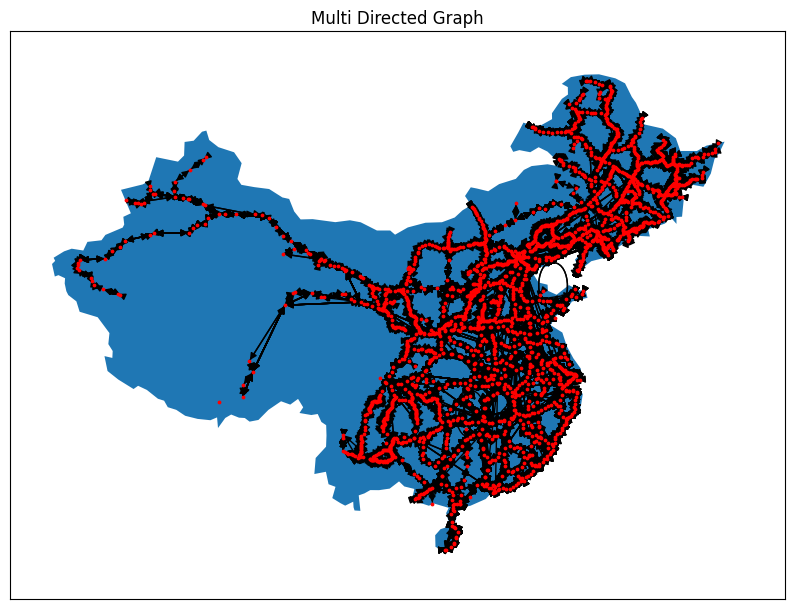

In [17]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

china=world[world['name'] == 'China']
china.plot(figsize=(10,10))

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G,pos, with_labels=False, node_size=3, node_color='red')

plt.axis('on')
plt.title("Multi Directed Graph")

plt.show()

## Directed Graph

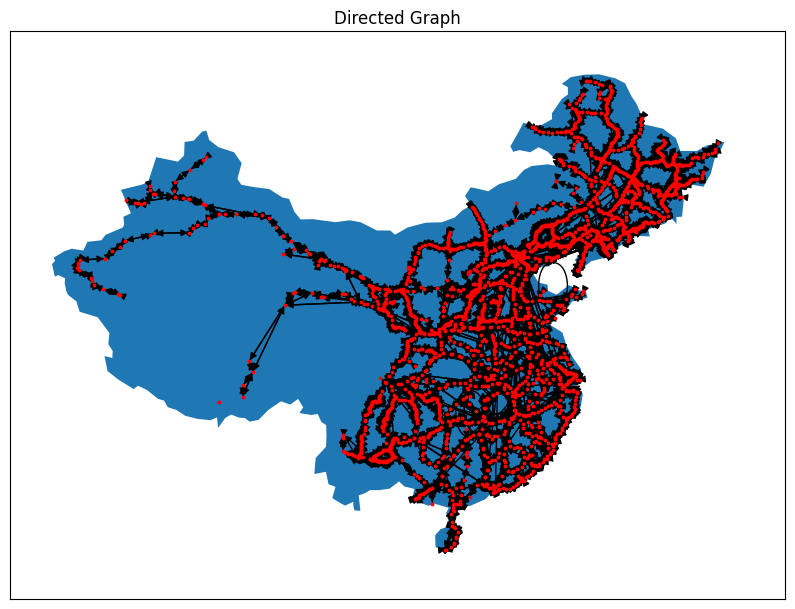

In [18]:
china.plot(figsize=(10,10))
pos = nx.get_node_attributes(G_directed, 'pos')
nx.draw(G_directed,pos, with_labels=False, node_size=3, node_color='red')

plt.axis('on')
plt.title("Directed Graph")

plt.show()

## Undirected Graph

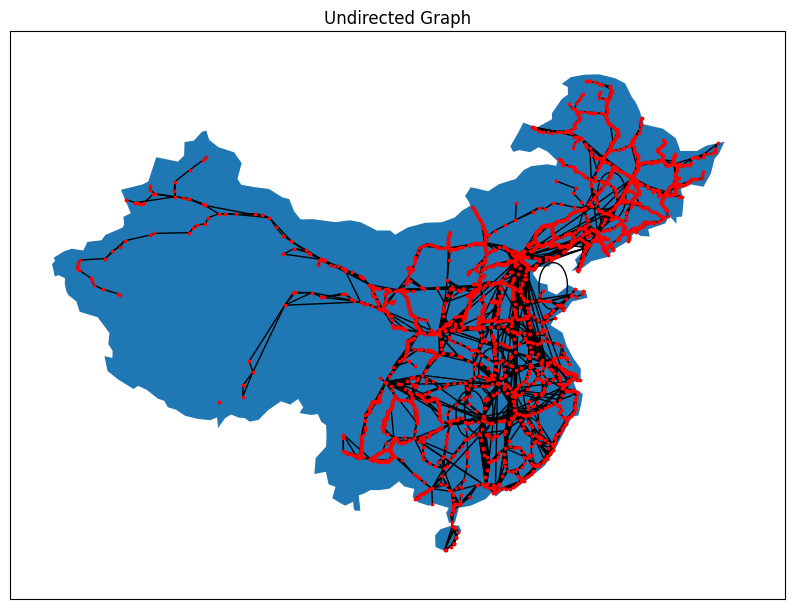

In [19]:
china.plot(figsize=(10,10))

pos = nx.get_node_attributes(G_undirected, 'pos')
nx.draw(G_undirected,pos, with_labels=False, node_size=3, node_color='red')

plt.axis('on')
plt.title("Undirected Graph")

plt.show()

# Temporal Graph with video

In [6]:
G_temp = nx.DiGraph()

# add nodes to the graph
for stations in network:
    for station in network[stations]:
        G_temp.add_node(station['id'], pos=(station['lon'], station['lat']))

# add edges to the graph
for stations in network:
    for station in network[stations]:
        from_node = station['id']
        to_node = None

        if type(station['to']) is tuple:
            # if the 'to' value is a tuple, create a new node
            to_node = station_id[station['to']]
            G_temp.add_edge(from_node, to_node, start=station['start'], end=station['end'])
        else:
            continue

### Create frames of the graph
May take very long to create all of the frame images for 2 Days, one frame is created every 5 minute. You may change the range to create less frames and a shorter video.

In [7]:
temporal_graphs = []
for i in range(0, 48*60, 1):
    G = nx.DiGraph()
    for u, v, d in G_temp.edges(data=True):
        if d['start'] <= i and d['end'] >= i:
            G.add_edge(u, v)
    #add node positions
    for u, v in G_temp.nodes(data=True):
        G.add_node(u, pos=G_temp.nodes[u]['pos'])
    temporal_graphs.append(G)

    # china.plot(figsize=(10,10))
    # nx.draw(G, pos=nx.get_node_attributes(G, 'pos'),with_labels=False, node_size=1, node_color='red')
    # plt.axis('on')
    # plt.title(f"Temporal Graph at {i//1440}:{(i//60)%24:02d}:{i%60:02d}")
    # plt.savefig(f"frames/{i}.png")
    # # plt.show()
    # plt.close()

    # delete the graph to free up memory

    # print progress bar
    print(f"\r{i/48/60*100:.2f}%", end="")

99.97%

In [8]:
# Create a figure and subplot
fig, ax = plt.subplots()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
china=world[world['name'] == 'China']
# Draw the first graph
china.plot(ax=ax)
nx.draw(temporal_graphs[0], pos=nx.get_node_attributes(G, 'pos'),with_labels=False, node_size=1, node_color='red',ax=ax)
ax.set_title(f"Temporal Graph at {0//1440}:{(0//60)%24:02d}:{0%60:02d}")

# Create a slider widget
slider = widgets.IntSlider(min=0, max=len(temporal_graphs)-1, value=0, description='Timeframe')

# Define a function to update the plot when the slider is changed
def update_plot(val):
    val=val['new']
    ax.clear()
    china.plot(ax=ax)
    nx.draw(temporal_graphs[val], pos=nx.get_node_attributes(G, 'pos'),with_labels=False, node_size=1, node_color='red',ax=ax)
    ax.set_title(f"Temporal Graph at {val//1440}:{(val//60)%24:02d}:{val%60:02d}")
    plt.show()


# Attach the update function to the slider
slider.observe(update_plot, names='value')

# Display the slider widget and plot
display(slider)
plt.show()

<IPython.core.display.Javascript object>

IntSlider(value=0, description='Timeframe', max=2879)

### Create a video of the graph with cv2 (OpenCV)

In [25]:
import cv2
import os

# Path to the folder containing the image frames
frames_folder = 'frames/'

# Get the list of frame filenames in the folder
frame_filenames = os.listdir(frames_folder)

# Sort the filenames in ascending order
frame_filenames.sort(key=lambda x: int(x[:-4]))

# Read the first frame to get its dimensions
frame = cv2.imread(frames_folder + frame_filenames[0])
height, width, layers = frame.shape

# Create a VideoWriter object to write the video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('output.mp4', fourcc, 30, (width, height))

# Loop through the frames and add them to the video
i=0
for filename in frame_filenames:
    frame = cv2.imread(frames_folder + filename)
    video.write(frame)
    print(f"\r{i/2764*100:.2f}%", end="")
    i+=1

# Release the VideoWriter object and display a message
video.release()
print('\nVideo saved as output.mp4')

100.00%Video saved as output.mp4


# SHORTEST PATH ANALYSIS

In [22]:
def shortest_path(G, source, target):
    return nx.shortest_path(G, source=source, target=target)

In [23]:
shortest_path(G, 1136, 1095)

[1136, 1763, 389, 1772, 2058, 802, 1070, 2065, 1100, 2144, 1095]

In [9]:
# Network Graph with the shortest path highlighted
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

china=world[world['name'] == 'China']
china.plot(figsize=(10,10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=1, node_color='red')

shortest_path = nx.shortest_path(G, source=1095, target=1136)
nx.draw_networkx_nodes(G, pos, nodelist=shortest_path, node_size=10, node_color='yellow')
nx.draw_networkx_edges(G, pos, edgelist=list(zip(shortest_path, shortest_path[1:])), edge_color='yellow', width=3)

plt.axis('on')
plt.title("Shortest Path between 1136 and 1095")
plt.show()


<IPython.core.display.Javascript object>

NetworkXNoPath: No path between 1095 and 1136.